In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

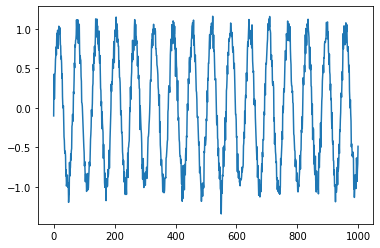

In [51]:
# make the original data
N = 1000
series = np.sin(0.1 * np.arange(N)) + np.random.randn(N) * 0.1

plt.plot(series);

In [52]:
# build the dataset
# let's see if we can use T past values to predict the next value

T = 10
X = []
Y = []

for t in range(len(series) - T):
  # setup frames
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (990, 10), Y.shape: (990, 1)


In [53]:
# Autoregressive Linear Model
model = nn.Linear(T, 1)

In [54]:
# Autoregressive ANN
model = nn.Sequential(
    nn.Linear(T, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

In [55]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [56]:
from sklearn.model_selection import train_test_split
# Shuffling would not make sense because a real forecasting model has to predict
# the future, it can't train on the points within the future.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.5, shuffle=False)
# Checking whether train_test_split function works as expected
np.allclose(Xtrain, X[:N//2]) # True

True

In [57]:
# Make inputs and targets
Xtrain = torch.from_numpy(Xtrain.astype(np.float32))
Ytrain = torch.from_numpy(Ytrain.astype(np.float32))
Xtest = torch.from_numpy(Xtest.astype(np.float32))
Ytest = torch.from_numpy(Ytest.astype(np.float32))

In [58]:
# Training
def full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest, epochs=200):

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):

    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(Xtrain)
    loss = criterion(outputs, Ytrain)

    # Backward and Optimize
    loss.backward()
    optimizer.step()
    train_losses[i] = loss.item()

    # Evaluation
    test_outputs = model(Xtest)
    test_loss = criterion(test_outputs, Ytest)
    test_losses[i] = test_loss.item()

    if (i+1) % 5 == 0:
      print(f"Epoch: {i+1}/{epochs}, Train Loss:{train_losses[i]:.4f}, Test Loss:{test_losses[i]:.4f}")
  
  return train_losses, test_losses

In [59]:
train_losses, test_losses = full_gd(model, criterion, optimizer, Xtrain, Ytrain, Xtest, Ytest)

Epoch: 5/200, Train Loss:0.1782, Test Loss:0.0843
Epoch: 10/200, Train Loss:0.0777, Test Loss:0.0590
Epoch: 15/200, Train Loss:0.0379, Test Loss:0.0420
Epoch: 20/200, Train Loss:0.0203, Test Loss:0.0228
Epoch: 25/200, Train Loss:0.0271, Test Loss:0.0245
Epoch: 30/200, Train Loss:0.0176, Test Loss:0.0183
Epoch: 35/200, Train Loss:0.0180, Test Loss:0.0186
Epoch: 40/200, Train Loss:0.0159, Test Loss:0.0166
Epoch: 45/200, Train Loss:0.0151, Test Loss:0.0167
Epoch: 50/200, Train Loss:0.0152, Test Loss:0.0156
Epoch: 55/200, Train Loss:0.0143, Test Loss:0.0156
Epoch: 60/200, Train Loss:0.0145, Test Loss:0.0153
Epoch: 65/200, Train Loss:0.0142, Test Loss:0.0152
Epoch: 70/200, Train Loss:0.0141, Test Loss:0.0153
Epoch: 75/200, Train Loss:0.0140, Test Loss:0.0152
Epoch: 80/200, Train Loss:0.0138, Test Loss:0.0152
Epoch: 85/200, Train Loss:0.0137, Test Loss:0.0151
Epoch: 90/200, Train Loss:0.0136, Test Loss:0.0152
Epoch: 95/200, Train Loss:0.0135, Test Loss:0.0152
Epoch: 100/200, Train Loss:0.013

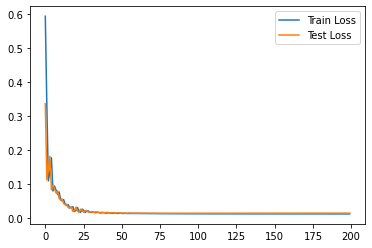

In [60]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [61]:
# Wrong forecast using true targets
predictions = []

# index of first validation input
i = 0

while len(predictions) < len(Ytest):
  # Xtest.shape => N x T (2-D array)
  # Xtest[i].shape => T (1-D array)
  # We want Xtest to be 1 x T (2-D array)
  input_ = Xtest[i].view(1, -1)
  p = model(input_)[0, 0].item() # 1x1 array, scalar
  i += 1

  predictions.append(p)


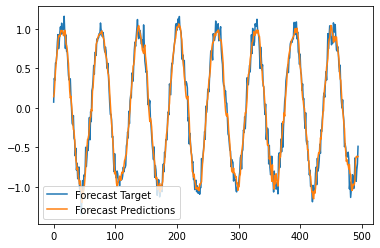

In [62]:
plt.plot(Ytest, label='Forecast Target')
plt.plot(predictions, label="Forecast Predictions")
plt.legend();

In [63]:
# Right forecast using true targets
right_predictions = []

# last train input
# 1-D array of length T
# We will no longer take any new values from actual dataset
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(right_predictions) < len(Ytest):
  input_ = last_x.view(1, -1)
  p = model(input_)
  # [0, 0] # 1x1 array -> scalar

  right_predictions.append(p[0, 0].item())

  # make the new input by concatenating
  last_x = torch.cat((last_x[1:], p[0]))

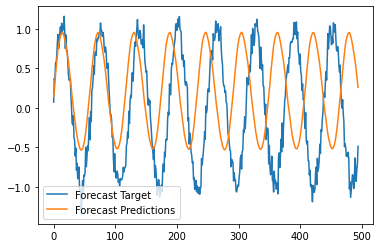

In [64]:
plt.plot(Ytest, label='Forecast Target')
plt.plot(right_predictions, label="Forecast Predictions")
plt.legend();